# SYSID - Atividade 03

Aluno: Pedro Henrique Cardoso Paulo

Professor: Helon Ayala

## Objetivo

O objetivo do código aqui mostrado é realizar testes estatísticos em cima dos dados usados na <a href="../Atividade02/Atividade02.ipynb">Atividade 2</a>.

## Passo 0 - Inicializando o Nb

### 0.1 - Limpando memória, prompt e inicializando random seed

In [2]:
% MEC 2015 System identification
% Prof Helon Ayala

clc
clear
close all
%rng(1) % permite reproducibilidade (indisponivel no octave 6 que usei)
%random_seed = 1;
%randn("seed", random_seed);

### 0.2 - Importando pacotes

Parra esse caso, não serão necessários pacotes.

In [2]:
%pkg load control %pkg control: funcoes de transferencia e c2d

## Passo 1 - Carregando os dados

Para esse caso, serão usados dados reais de um braço robótico. Os dados podem ser baixados no seguinte endereço:

<a>https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/robot_arm.dat.gz</a>

Os dados foram baixados compactados e extraídos, resultando em um arquivo de texto.

### 1.1 - Importando os dados

In [3]:
DATA = dlmread('../data/robot_arm.dat');
Y = DATA(:,1);
U = DATA(:,2);

% vetor tempo discreto
t = (1:length(Y));

Espera-se que um ajuste por mínimos quadrados retorne um vetor $\theta$ similar ao descrito.

### 1.2 - Visualizando os dados

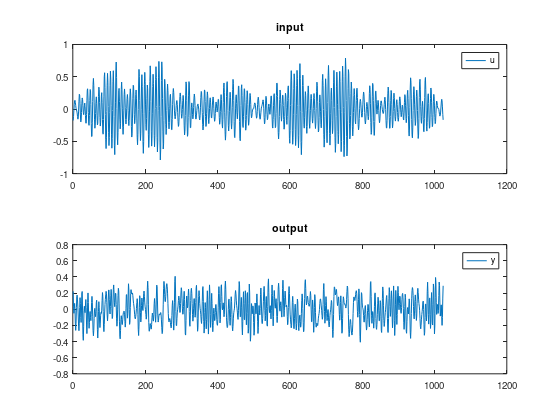

In [4]:
% plot training data
figure
subplot(2,1,1)
plot(t,U)
title('input')
legend('u');
subplot(2,1,2)
plot(t,Y)
title('output')
legend('y');

### 1.3 - Dividindo dados em treino e validação

Para esse exercício, vamos propor uma divisão do trend em 50% de dados para o treino e 50% para a validação

In [5]:
train_fraction = 0.5; % Fracao de valores para treino
n = length(t);

n_TRA = round(n*train_fraction) % Numero de elementos para treino
n_VAL = n - n_TRA

tTRA = t(1:n_TRA);
tVAL = t(n_TRA+1:end);

YTRA = Y(1:n_TRA);
YVAL = Y(n_TRA+1:end);

UTRA = U(1:n_TRA);
UVAL = U(n_TRA+1:end);


n_TRA = 512
n_VAL = 512


## Parte 2 - Realizando ajuste

Nessa primeira etapa vamos tentar ajustar nosso problema com um modelo de ordem 2 e ver os resultados. Em etapa posterior, tentaremos variar a ordem apra identificar uma razoável.

### 2.1 - Calculando matriz de regressão para ambos os trends

In [6]:
[Phi, Y1]    = matReg (YTRA, UTRA, 2, 2);
[PhiVAL, Y2] = matReg (YVAL, UVAL, 2, 2);

### 2.2 - Estimando os parâmetros

In [7]:
% estimate parameters:
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1 % batch least squares

th_hat =

  -1.3183e+00
   8.3163e-01
  -2.8600e-02
   9.8204e-04



## Parte 3 - Comparação dos resultados

### 3.1 - Realizando a simulação

In [8]:
% one step ahead prediction
yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, 2, 2);
yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, 2, 2);

[yhat_VAL_OSA yhat_VAL_FS];

### 3.2 - Comparando conjunto de treino

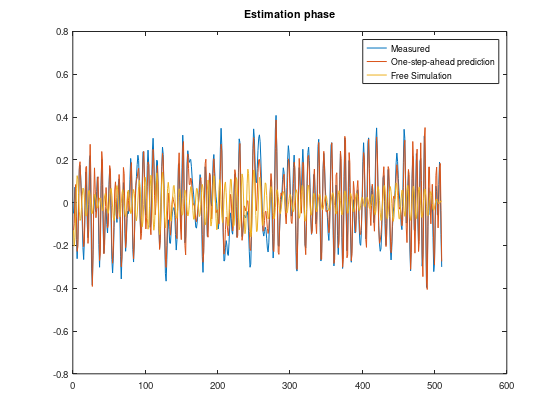

In [10]:
% plot predictions
figure
plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
title('Estimation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 3.3 - Comparando resultados da validação

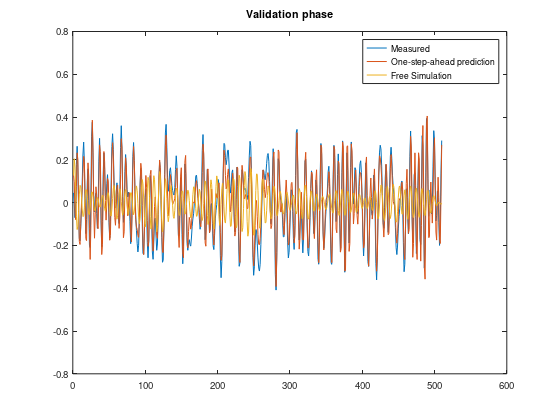

In [11]:
figure
plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
title('Validation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 3.4 - Extraindo as métricas $R^2$

A métrica $R^2$ é definida por meio da seguinte expressão:

$
R^2 = 1 - \frac{\sum^N_{t=1} [\xi(t)]^2}{\sum^N_{t=1} [y(t)-\bar{y}]^2}
$

Essa métrica é uma medida de correlação entre os dados estimados e os dados reais, em que o quãao mais próximo $R^2$ é de 1, melhor é o ajuste. Calculando a métrica:

In [12]:
R2_TRA_OSA = mult_corr(Y1,yhat_TRA_OSA);
R2_VAL_OSA = mult_corr(Y2,yhat_VAL_OSA);
R2_TRA_FS  = mult_corr(Y1,yhat_TRA_FS);
R2_VAL_FS  = mult_corr(Y2,yhat_VAL_FS);

fprintf('R2 obtained (1 is perfect) \n')
fprintf('R2_TRA_OSA \t R2_VAL_OSA \t R2_TRA_FS \t R2_VAL_FS\n')
fprintf('%0.4f \t\t %0.4f \t\t %0.4f \t %0.4f\n',R2_TRA_OSA,R2_VAL_OSA,R2_TRA_FS,R2_VAL_FS)

R2 obtained (1 is perfect) 
R2_TRA_OSA 	 R2_VAL_OSA 	 R2_TRA_FS 	 R2_VAL_FS
0.8489 		 0.8474 		 -0.0761 	 -0.0726


### 3.5 - Plotando testes estatísticos

Os testes estatísticos são outra forma de avaliar a qualidade do ajuste. O principal teste estatístico levado em conta é a autocorrelação, definida como:

$
\phi_{ab}(\tau) = \frac{\sum^N_{t=1} [a(t)-\bar{a}][b(t+\tau)-\bar{b}]}{\left[\left[\sum^N_{t=1} [a(t)-\bar{a}]^2\right]\left[\sum^N_{t=1} [b(t)-\bar{b}]^2\right]\right]^{\frac{1}{2}}}
$

Para um modelo linear simples, como o que esperamos, os principais testes estatísticos relevantes são:

$
\begin{cases}
\phi_{\xi\xi} = \delta(\tau), \\
\phi_{u\xi} = 0
\end{cases}
$

Caso ambos os critérios sejam atendidos para todo $\tau$, podemos provar que o erro é aleatório e que não devemos ter ganho aumentando a ordem do modelo. Esses testes correspondem aos dois primeiros gráficos da função a seguir:

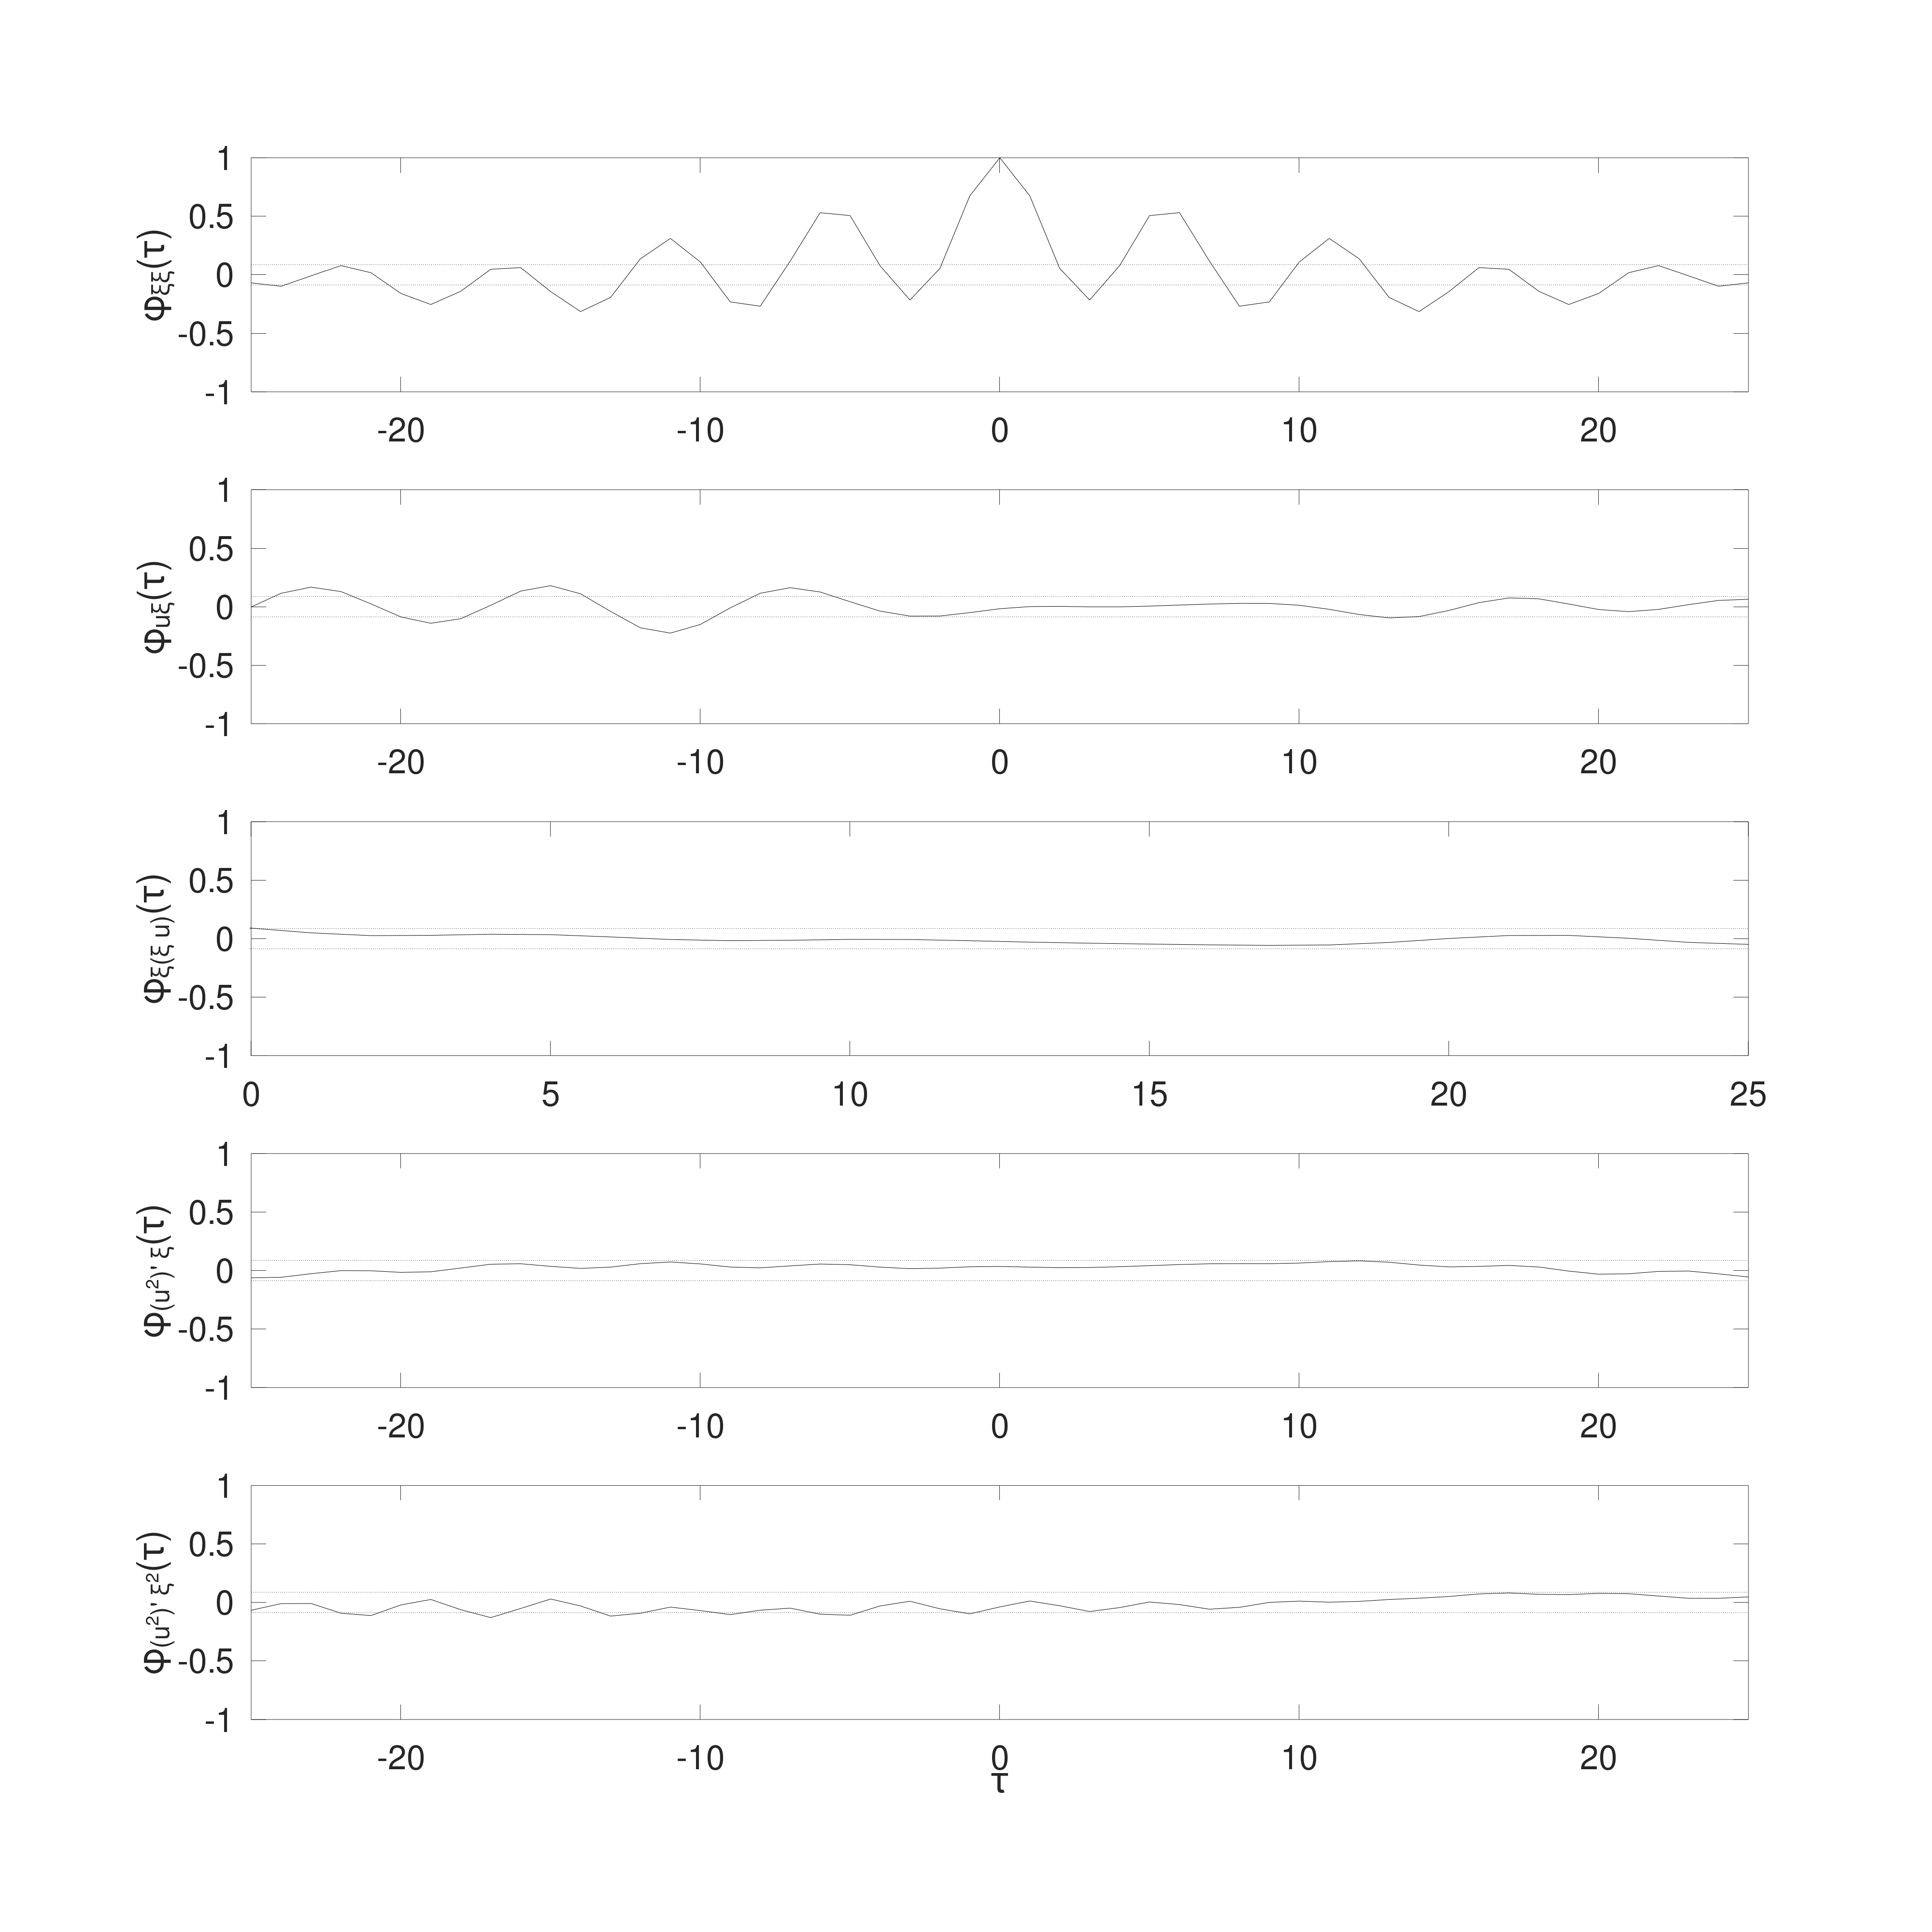

In [14]:
plot_xcorrel(Y1-yhat_TRA_OSA,UTRA(3:end))

### 3.4 - Conclusões da comparação

Os valores estimados de $R^2$ corroboram as conclusões da tarefa anterior sobre a qualidade do modelo, em que fica clara  a qualidade mediana do modelo de ordem 2 para a simulação OSA e a pouca qualidade do modelo para a FS. Além disso, os testes estatísticos demostram que o modelo está muito longe do ideal, com o erro não sendo apenas aleatório. Dessa forma, um aumento da ordem do modelo deve melhorar os resultados

## Parte 4 - Verificando o impacto da ordem do modelo

Nesta seção vamos fazer alguns testes com diferentes ordens de modelos com o objetivo de definir qual a melhor para representar o nosso problema. Os modelos serão comparados visualmente e através da métrica $R^2$

### 4.1 - Selecionando possíveis valores de na e nb

In [15]:
n_rng = (1:6);         %range de n's a testar
nns   = length(n_rng); %numero de n's a testar

### 4.2 - Realizando simulações

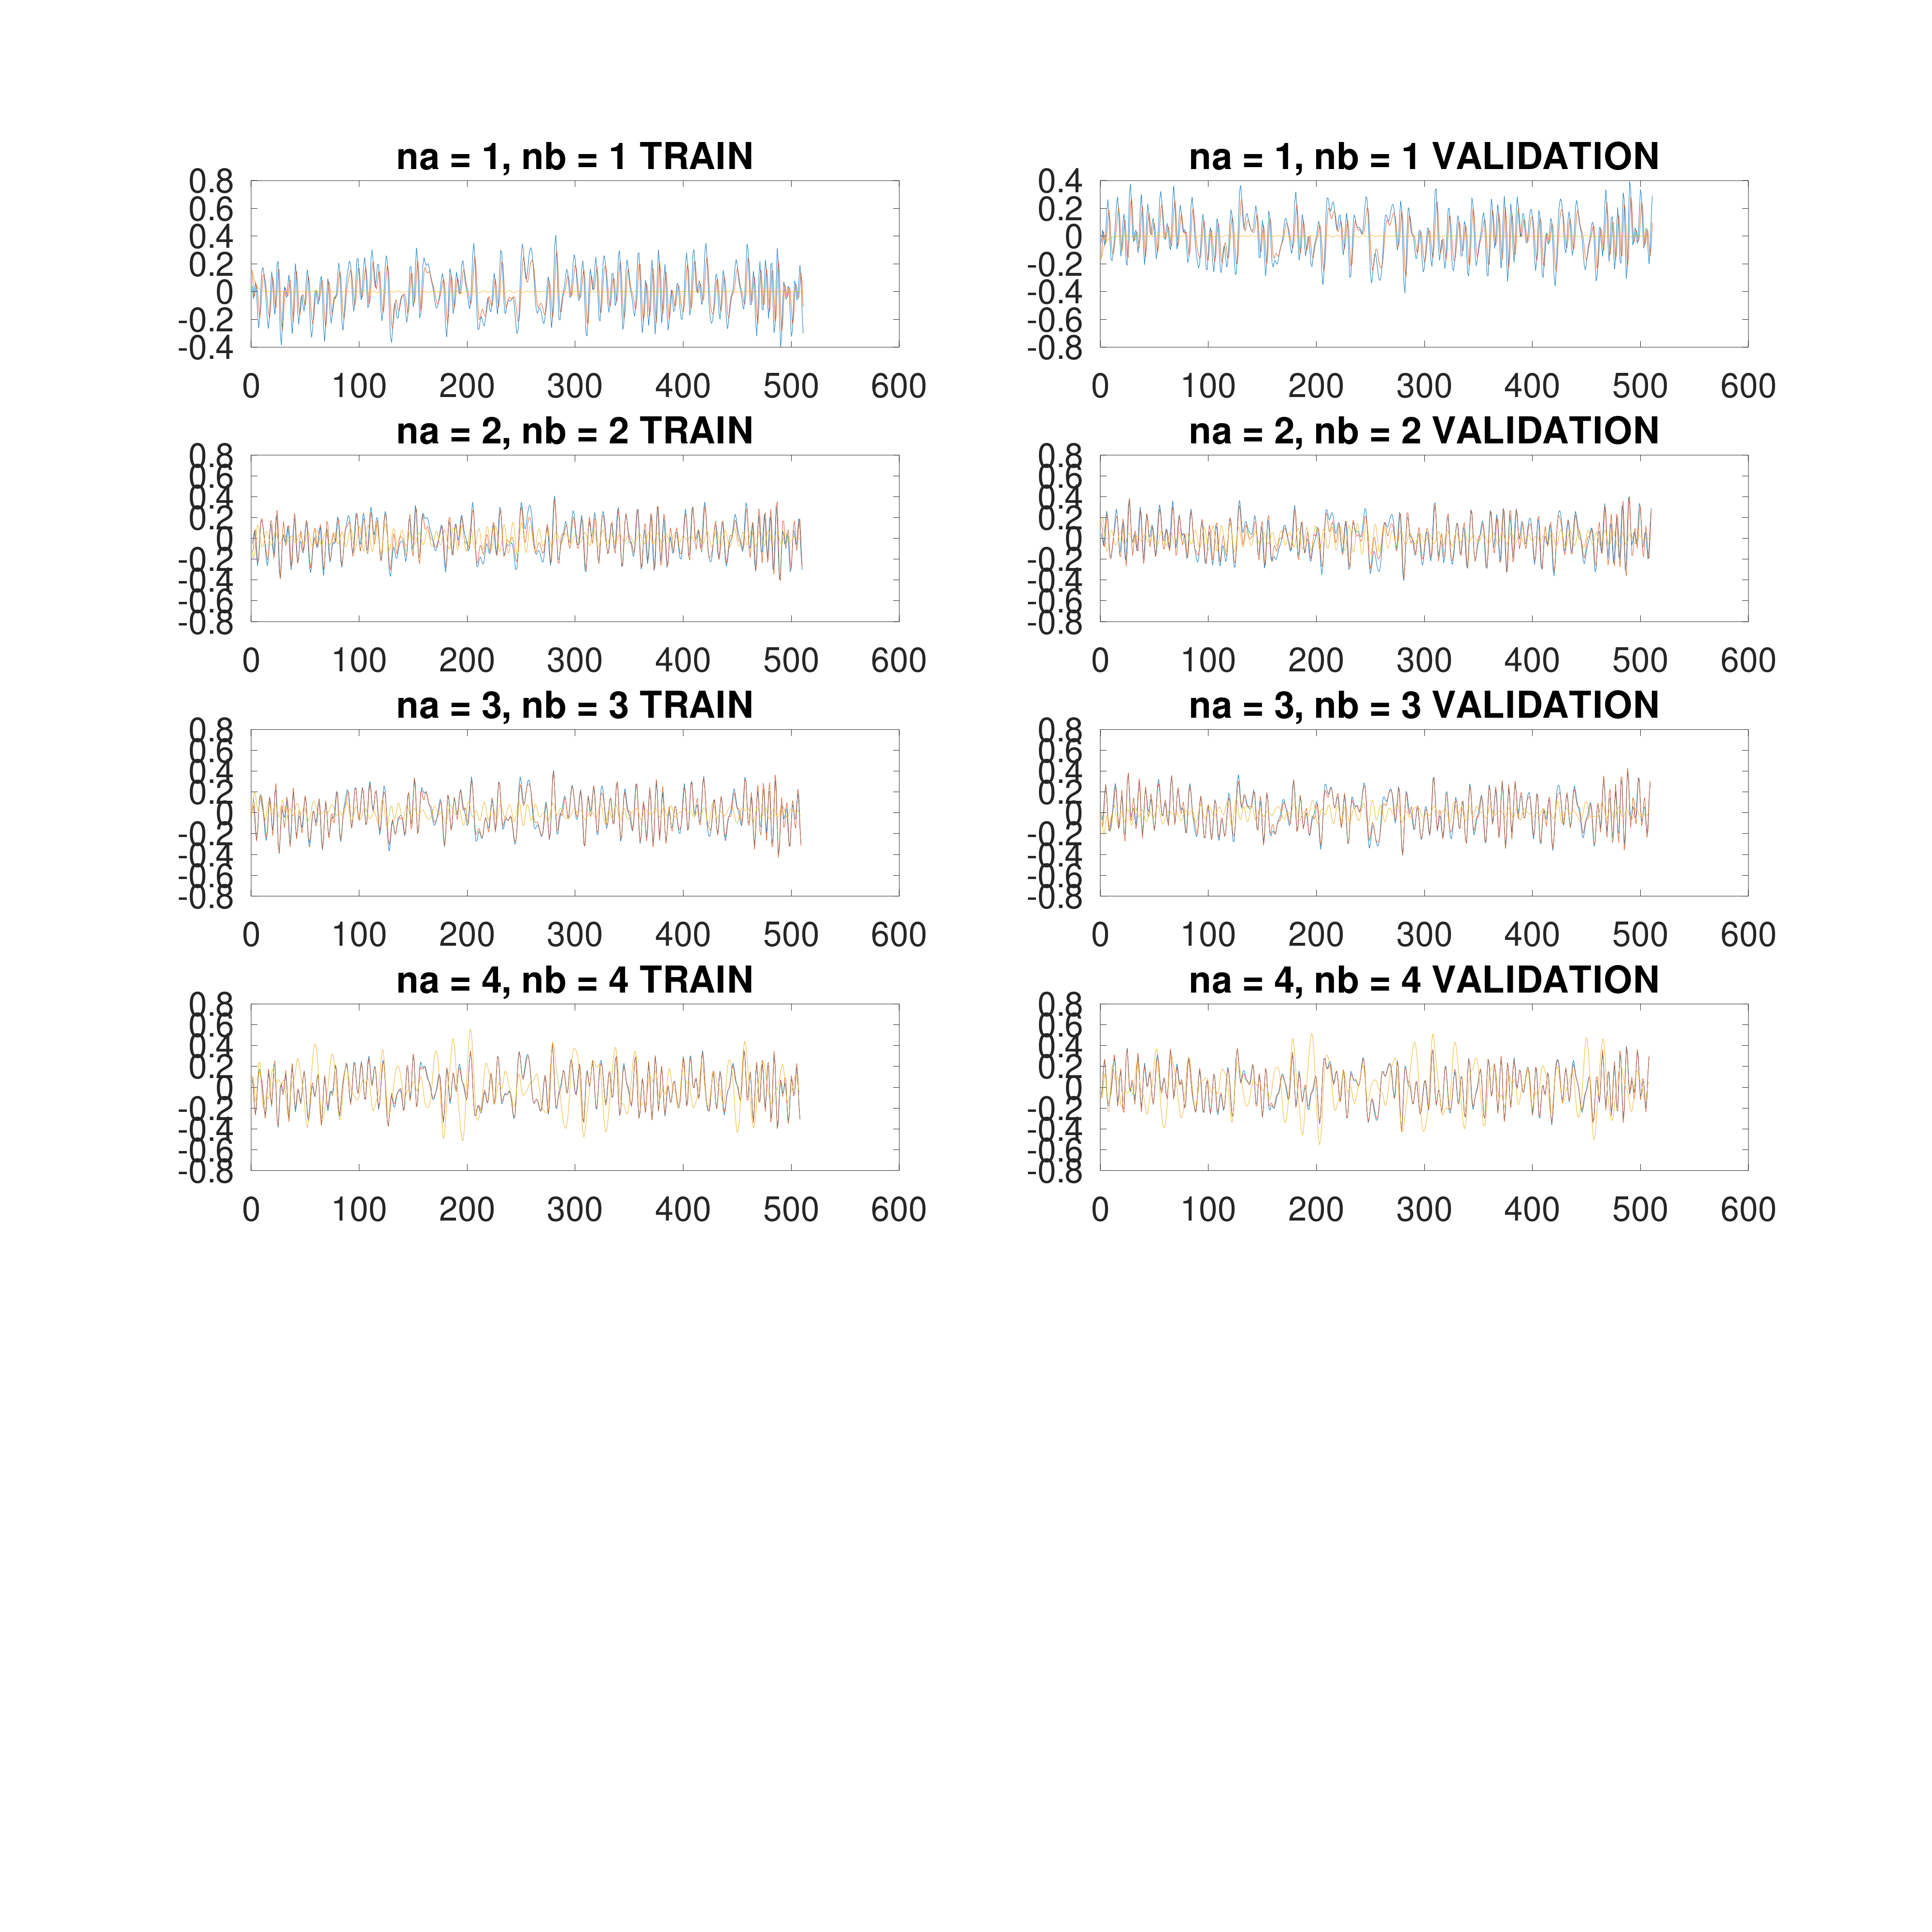

In [16]:
error_MODEL = [];
figure("position", [300 200 4000 4000])
index = 1;
for i=1:nns
    na = n_rng(i);
    nb = n_rng(i);
    %Step 1 - Gerando matriz
    [Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
    [PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

    %Step 2 - Resolvendo sistema
    th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

    %Step 3 - Simulando
    yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
    yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

    yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
    yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);

    %% Erro da simulacao
    R2_TRA_OSA = mult_corr(Y1,yhat_TRA_OSA);
    R2_VAL_OSA = mult_corr(Y2,yhat_VAL_OSA);
    R2_TRA_FS  = mult_corr(Y1,yhat_TRA_FS);
    R2_VAL_FS  = mult_corr(Y2,yhat_VAL_FS);

    error_MODEL = [error_MODEL; [na nb R2_TRA_OSA R2_VAL_OSA R2_TRA_FS R2_VAL_FS]];

    %Step 4 - Plotando
    subplot(nns,2,index)
    plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' TRAIN'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;
    

    subplot(nns,2,index)
    plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' VALIDATION'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;

endfor

$R^2$ calculados:

In [25]:
fprintf('R2 obtained (1 is perfect) \n')
fprintf( 'na \t\t nb \t\t R2_TRA_OSA \t\t R2_VAL_OSA \t\t R2_TRA_FS \t\ R2_VAL_FS\n')
for i=1:nns
    fprintf('%d \t\t %d \t\t %0.4f \t\t %0.4f \t\t %0.4e \t %0.4e\n',error_MODEL(i,1),error_MODEL(i,2),error_MODEL(i,3),error_MODEL(i,4),error_MODEL(i,5),error_MODEL(i,6))
endfor

R2 obtained (1 is perfect) 
na 		 nb 		 R2_TRA_OSA 		 R2_VAL_OSA 		 R2_TRA_FS 	 R2_VAL_FS
1 		 1 		 0.5205 		 0.5215 		 -6.2939e-03 	 -6.4644e-03
2 		 2 		 0.8489 		 0.8474 		 -7.6078e-02 	 -7.2622e-02
3 		 3 		 0.9514 		 0.9504 		 2.7452e-02 	 3.0403e-02
4 		 4 		 0.9855 		 0.9853 		 -6.9104e-01 	 -7.5545e-01
5 		 5 		 0.9963 		 0.9958 		 -5.9976e+286 	 -2.1753e+287
6 		 6 		 0.9994 		 0.9994 		 -Inf 	 -Inf


É possível notar que para casos de `na = nb >= 5` o modelo divergiu para a simulação livre, não gerando resultados. Por essa comparação o melhor resultado tenderia a ser `na = nb = 3` considerando o menor erro na FS. Vamos agora tentar tunar os parâmetros com base em `na` e `nb` individualmente.

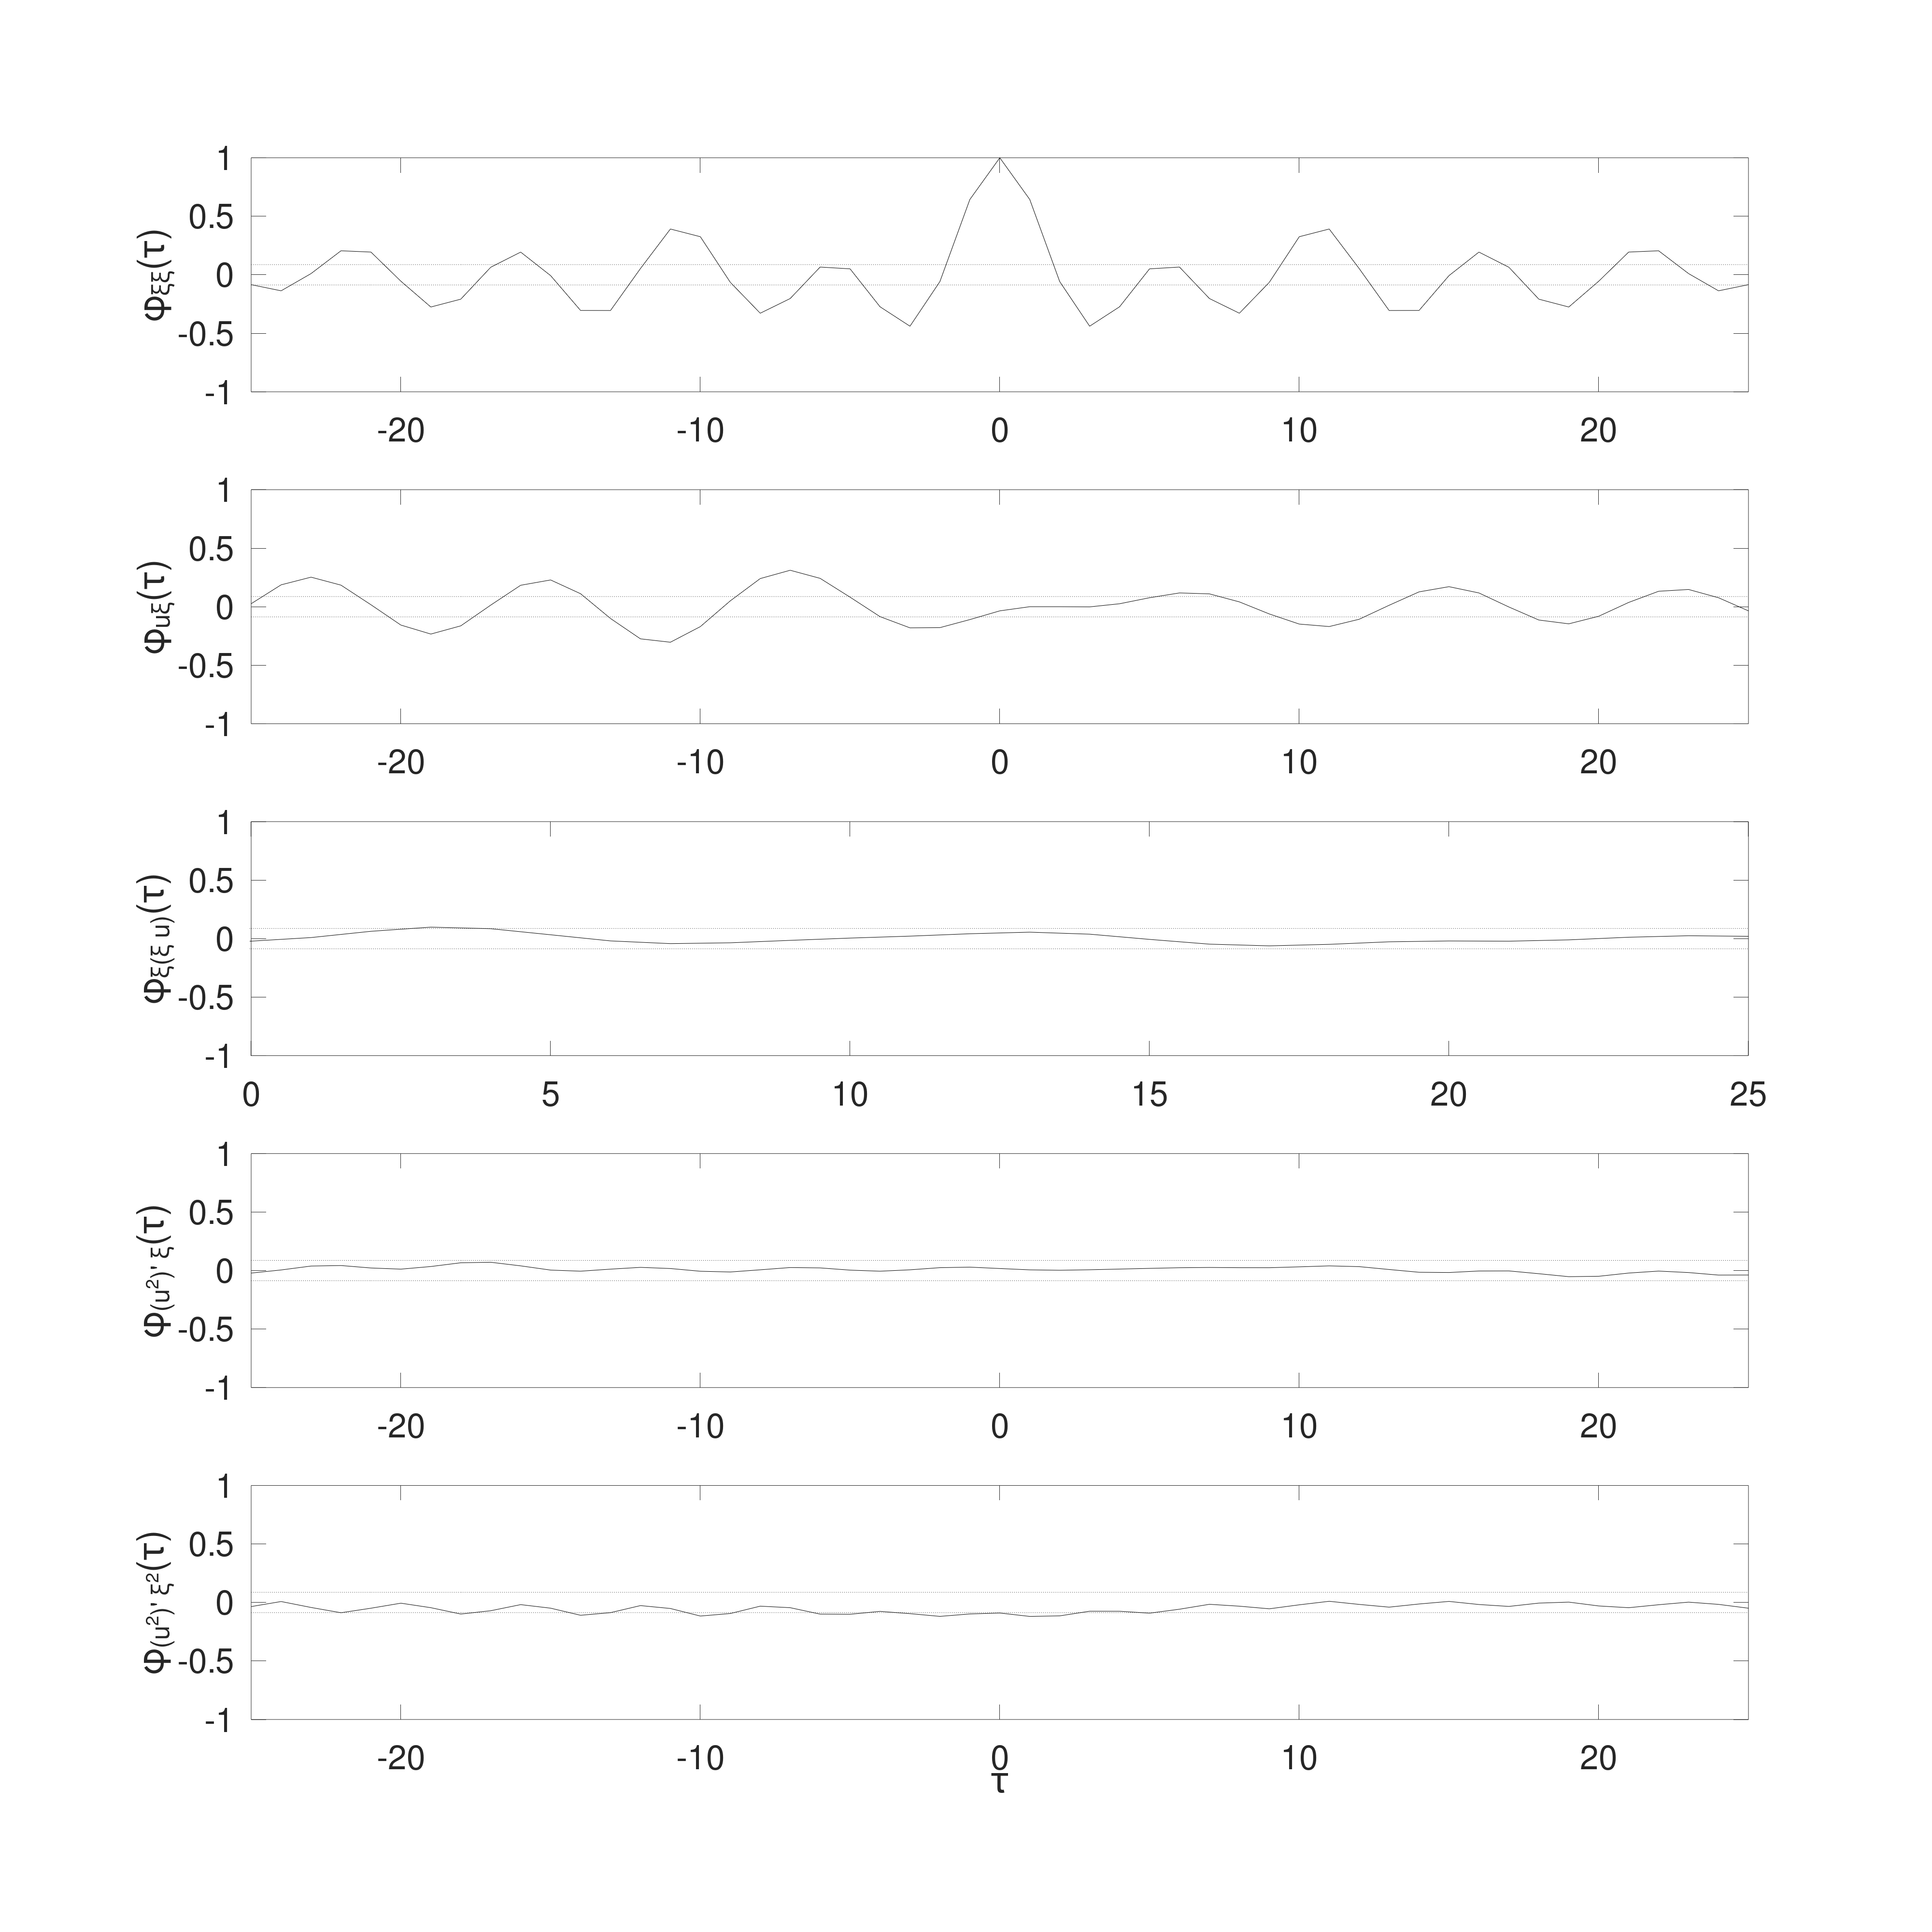

In [40]:
na = 3;
nb = 3;
p = max([na nb]);

%Step 1 - Gerando matriz
[Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
[PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

%Step 2 - Resolvendo sistema
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

%Step 3 - Simulando
yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);
plot_xcorrel(Y1-yhat_TRA_OSA,UTRA(p+1:end))

### 4.3 - Ajustando melhor `na` e `nb`:

Nessa caso, vamos usar `na` como parâmetro de ajuste e tentar selecionar o melhor valor com base numa sensibilidade em `nb`. O resultado atingiddo foi um `na = 2`, acima do qual temos o risco de divergência para bbalores altos de `nb`.

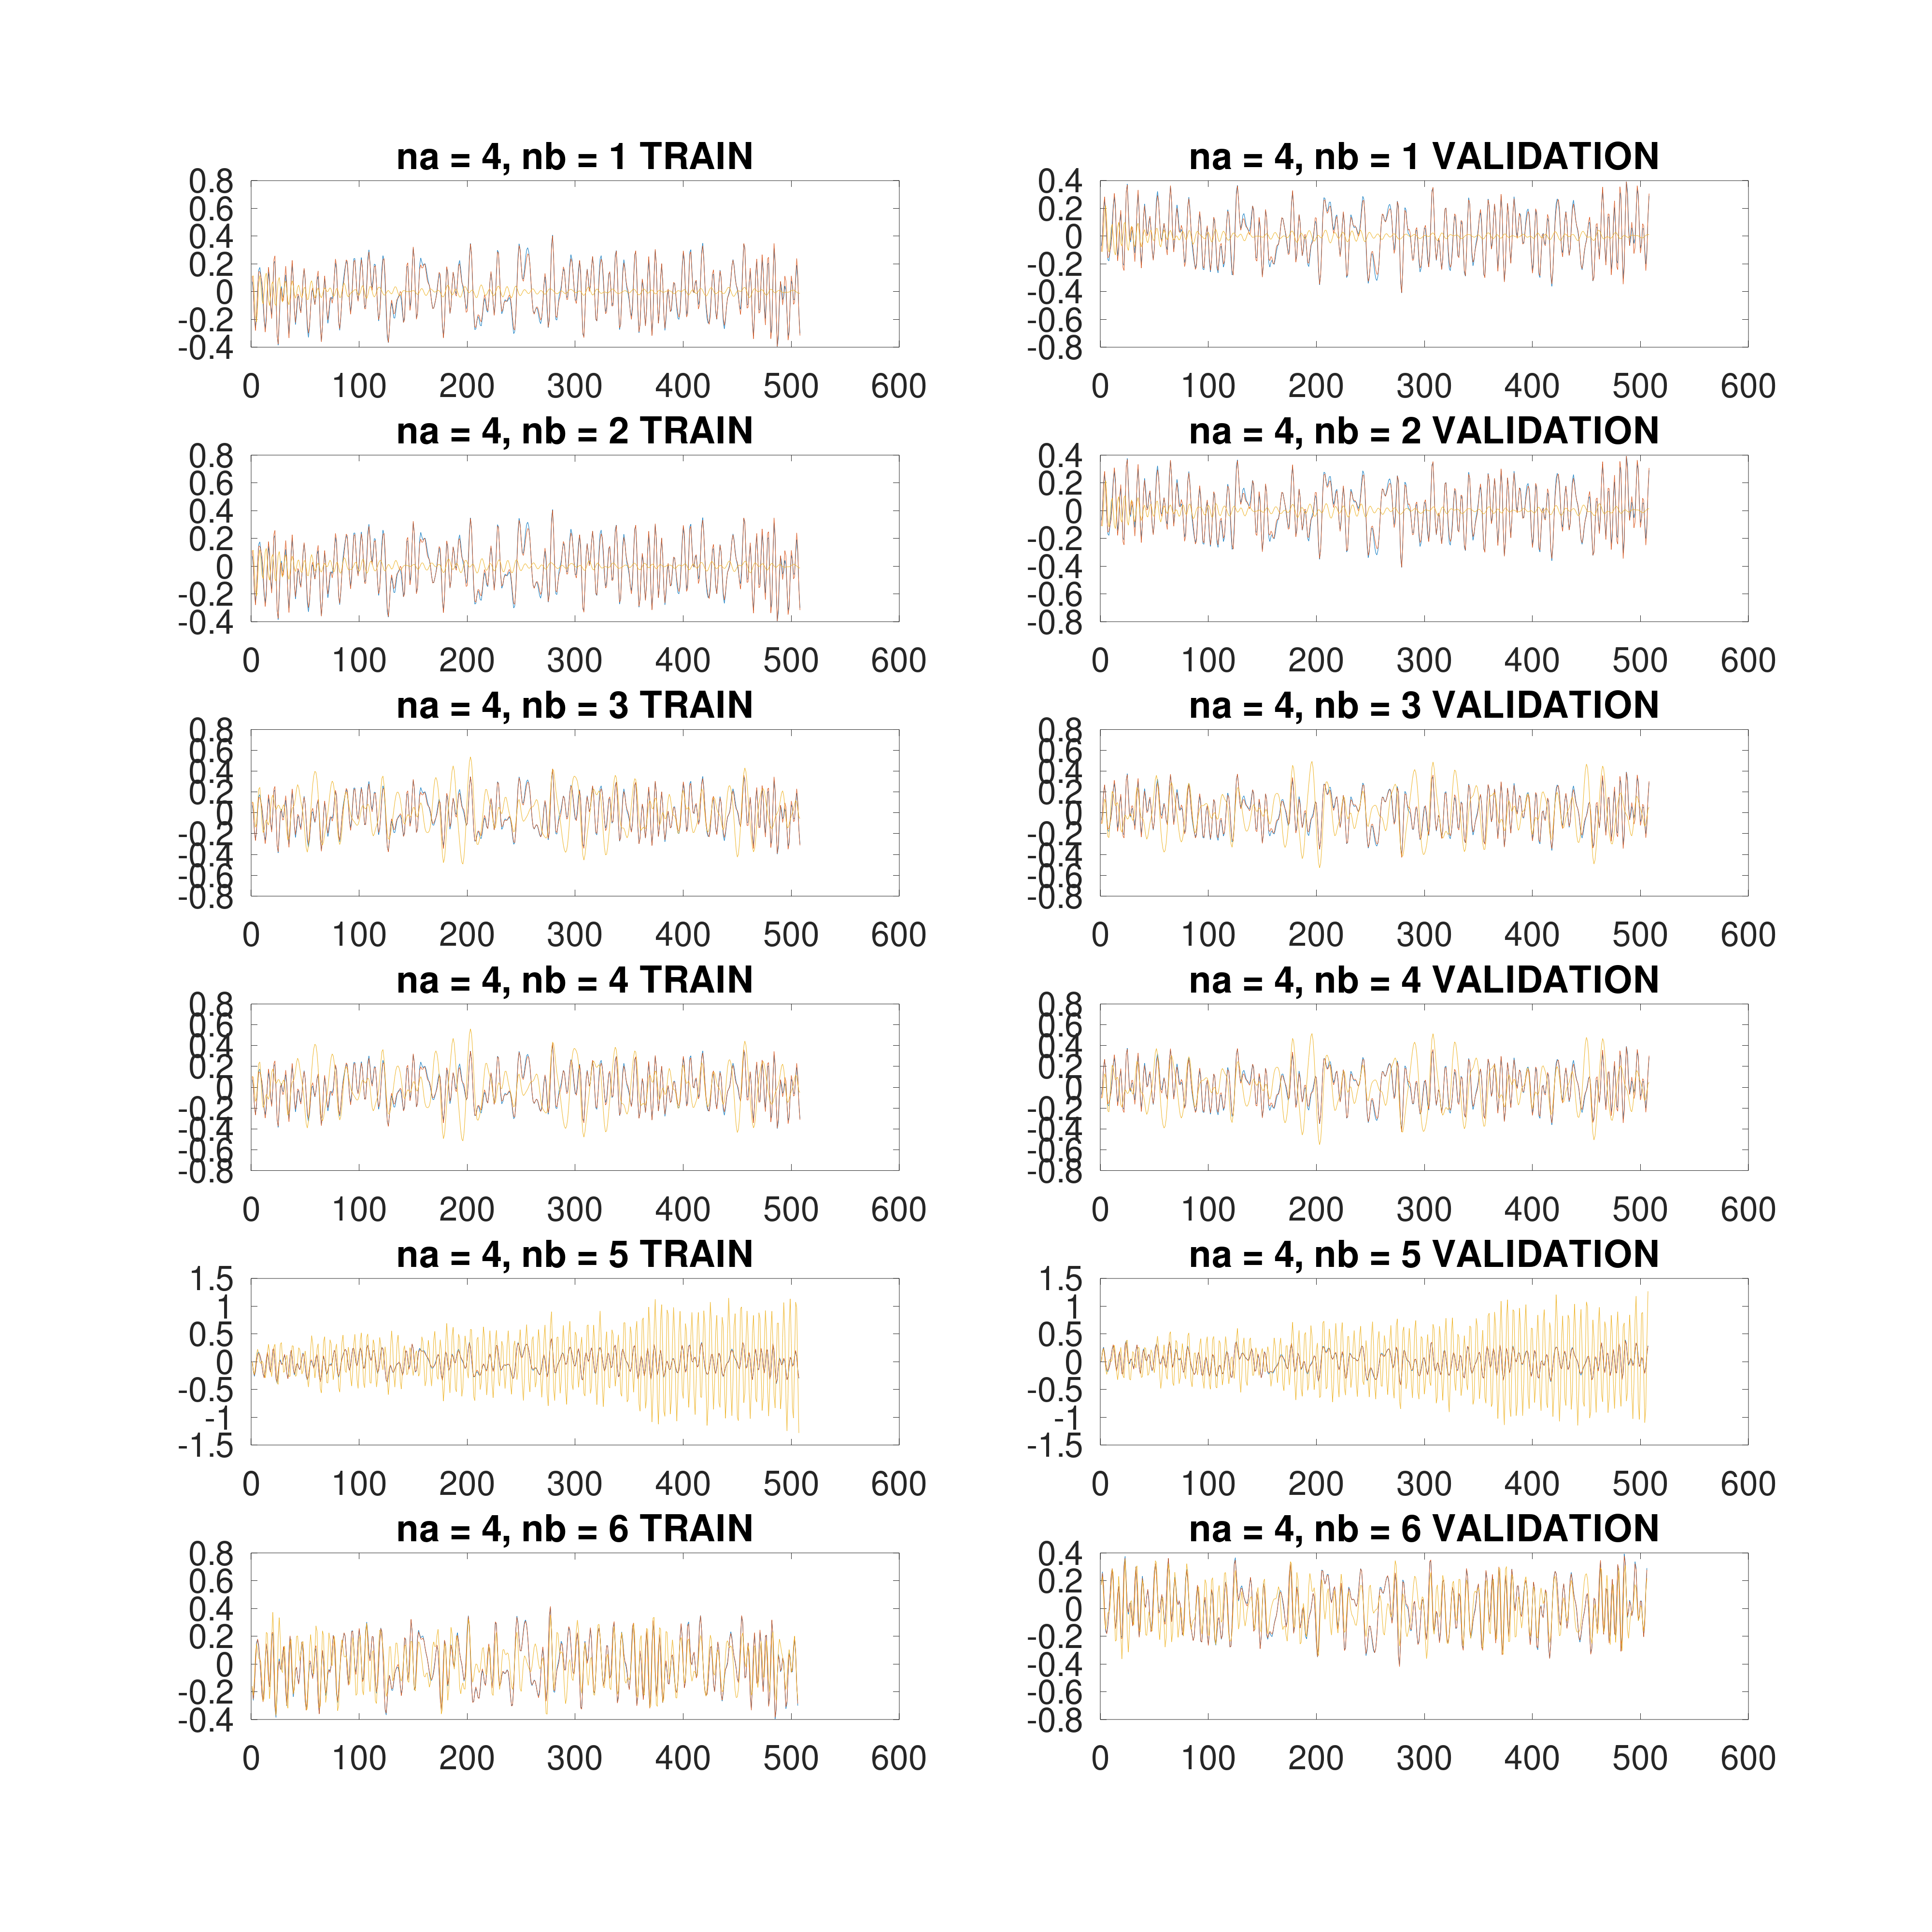

In [46]:

n_rng = (1:6);
nns = length(n_rng);
error_MODEL = [];
figure("position", [300 200 4000 4000])
index = 1;
for i=1:nns
    na = 4;%n_rng(i);
    nb = n_rng(i);
    %Step 1 - Gerando matriz
    [Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
    [PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

    %Step 2 - Resolvendo sistema
    th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

    %Step 3 - Simulando
    yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
    yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

    yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
    yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);

    %% Erro da simulacao
    R2_TRA_OSA = mult_corr(Y1,yhat_TRA_OSA);
    R2_VAL_OSA = mult_corr(Y2,yhat_VAL_OSA);
    R2_TRA_FS  = mult_corr(Y1,yhat_TRA_FS);
    R2_VAL_FS  = mult_corr(Y2,yhat_VAL_FS);

    error_MODEL = [error_MODEL; [na nb R2_TRA_OSA R2_VAL_OSA R2_TRA_FS R2_VAL_FS]];

    %Step 4 - Plotando
    subplot(nns,2,index)
    plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' TRAIN'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;
    

    subplot(nns,2,index)
    plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' VALIDATION'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;

endfor

$R^2$ calculados:

In [47]:
fprintf('R2 obtained (1 is perfect) \n')
fprintf( 'na \t\t nb \t\t R2_TRA_OSA \t\t R2_VAL_OSA \t\t R2_TRA_FS \t\ R2_VAL_FS\n')
for i=1:nns
    fprintf('%d \t\t %d \t\t %0.4f \t\t %0.4f \t\t %0.4e \t %0.4e\n',error_MODEL(i,1),error_MODEL(i,2),error_MODEL(i,3),error_MODEL(i,4),error_MODEL(i,5),error_MODEL(i,6))
endfor

R2 obtained (1 is perfect) 
na 		 nb 		 R2_TRA_OSA 		 R2_VAL_OSA 		 R2_TRA_FS 	 R2_VAL_FS
4 		 1 		 0.9816 		 0.9814 		 2.5106e-03 	 2.6098e-03
4 		 2 		 0.9816 		 0.9815 		 1.3291e-02 	 1.4676e-02
4 		 3 		 0.9855 		 0.9853 		 -6.0166e-01 	 -6.5894e-01
4 		 4 		 0.9855 		 0.9853 		 -6.9104e-01 	 -7.5545e-01
4 		 5 		 0.9932 		 0.9934 		 -8.0681e+00 	 -8.1426e+00
4 		 6 		 0.9967 		 0.9970 		 4.6632e-01 	 4.8194e-01


Usando agora $R^2$ como métrica para comparação podemos concluir que, embora  `na = 2` leve a bons resultados, como antes descrito na <a href="../Atividade02/Atividade02.ipynb">Atividade 2</a>, uma ordem de `na = 4` é o valor mais adequado ao problema considerando valores de OSA e FS para um par de `nb = 6` apenas. Assumindo este como caso base: 

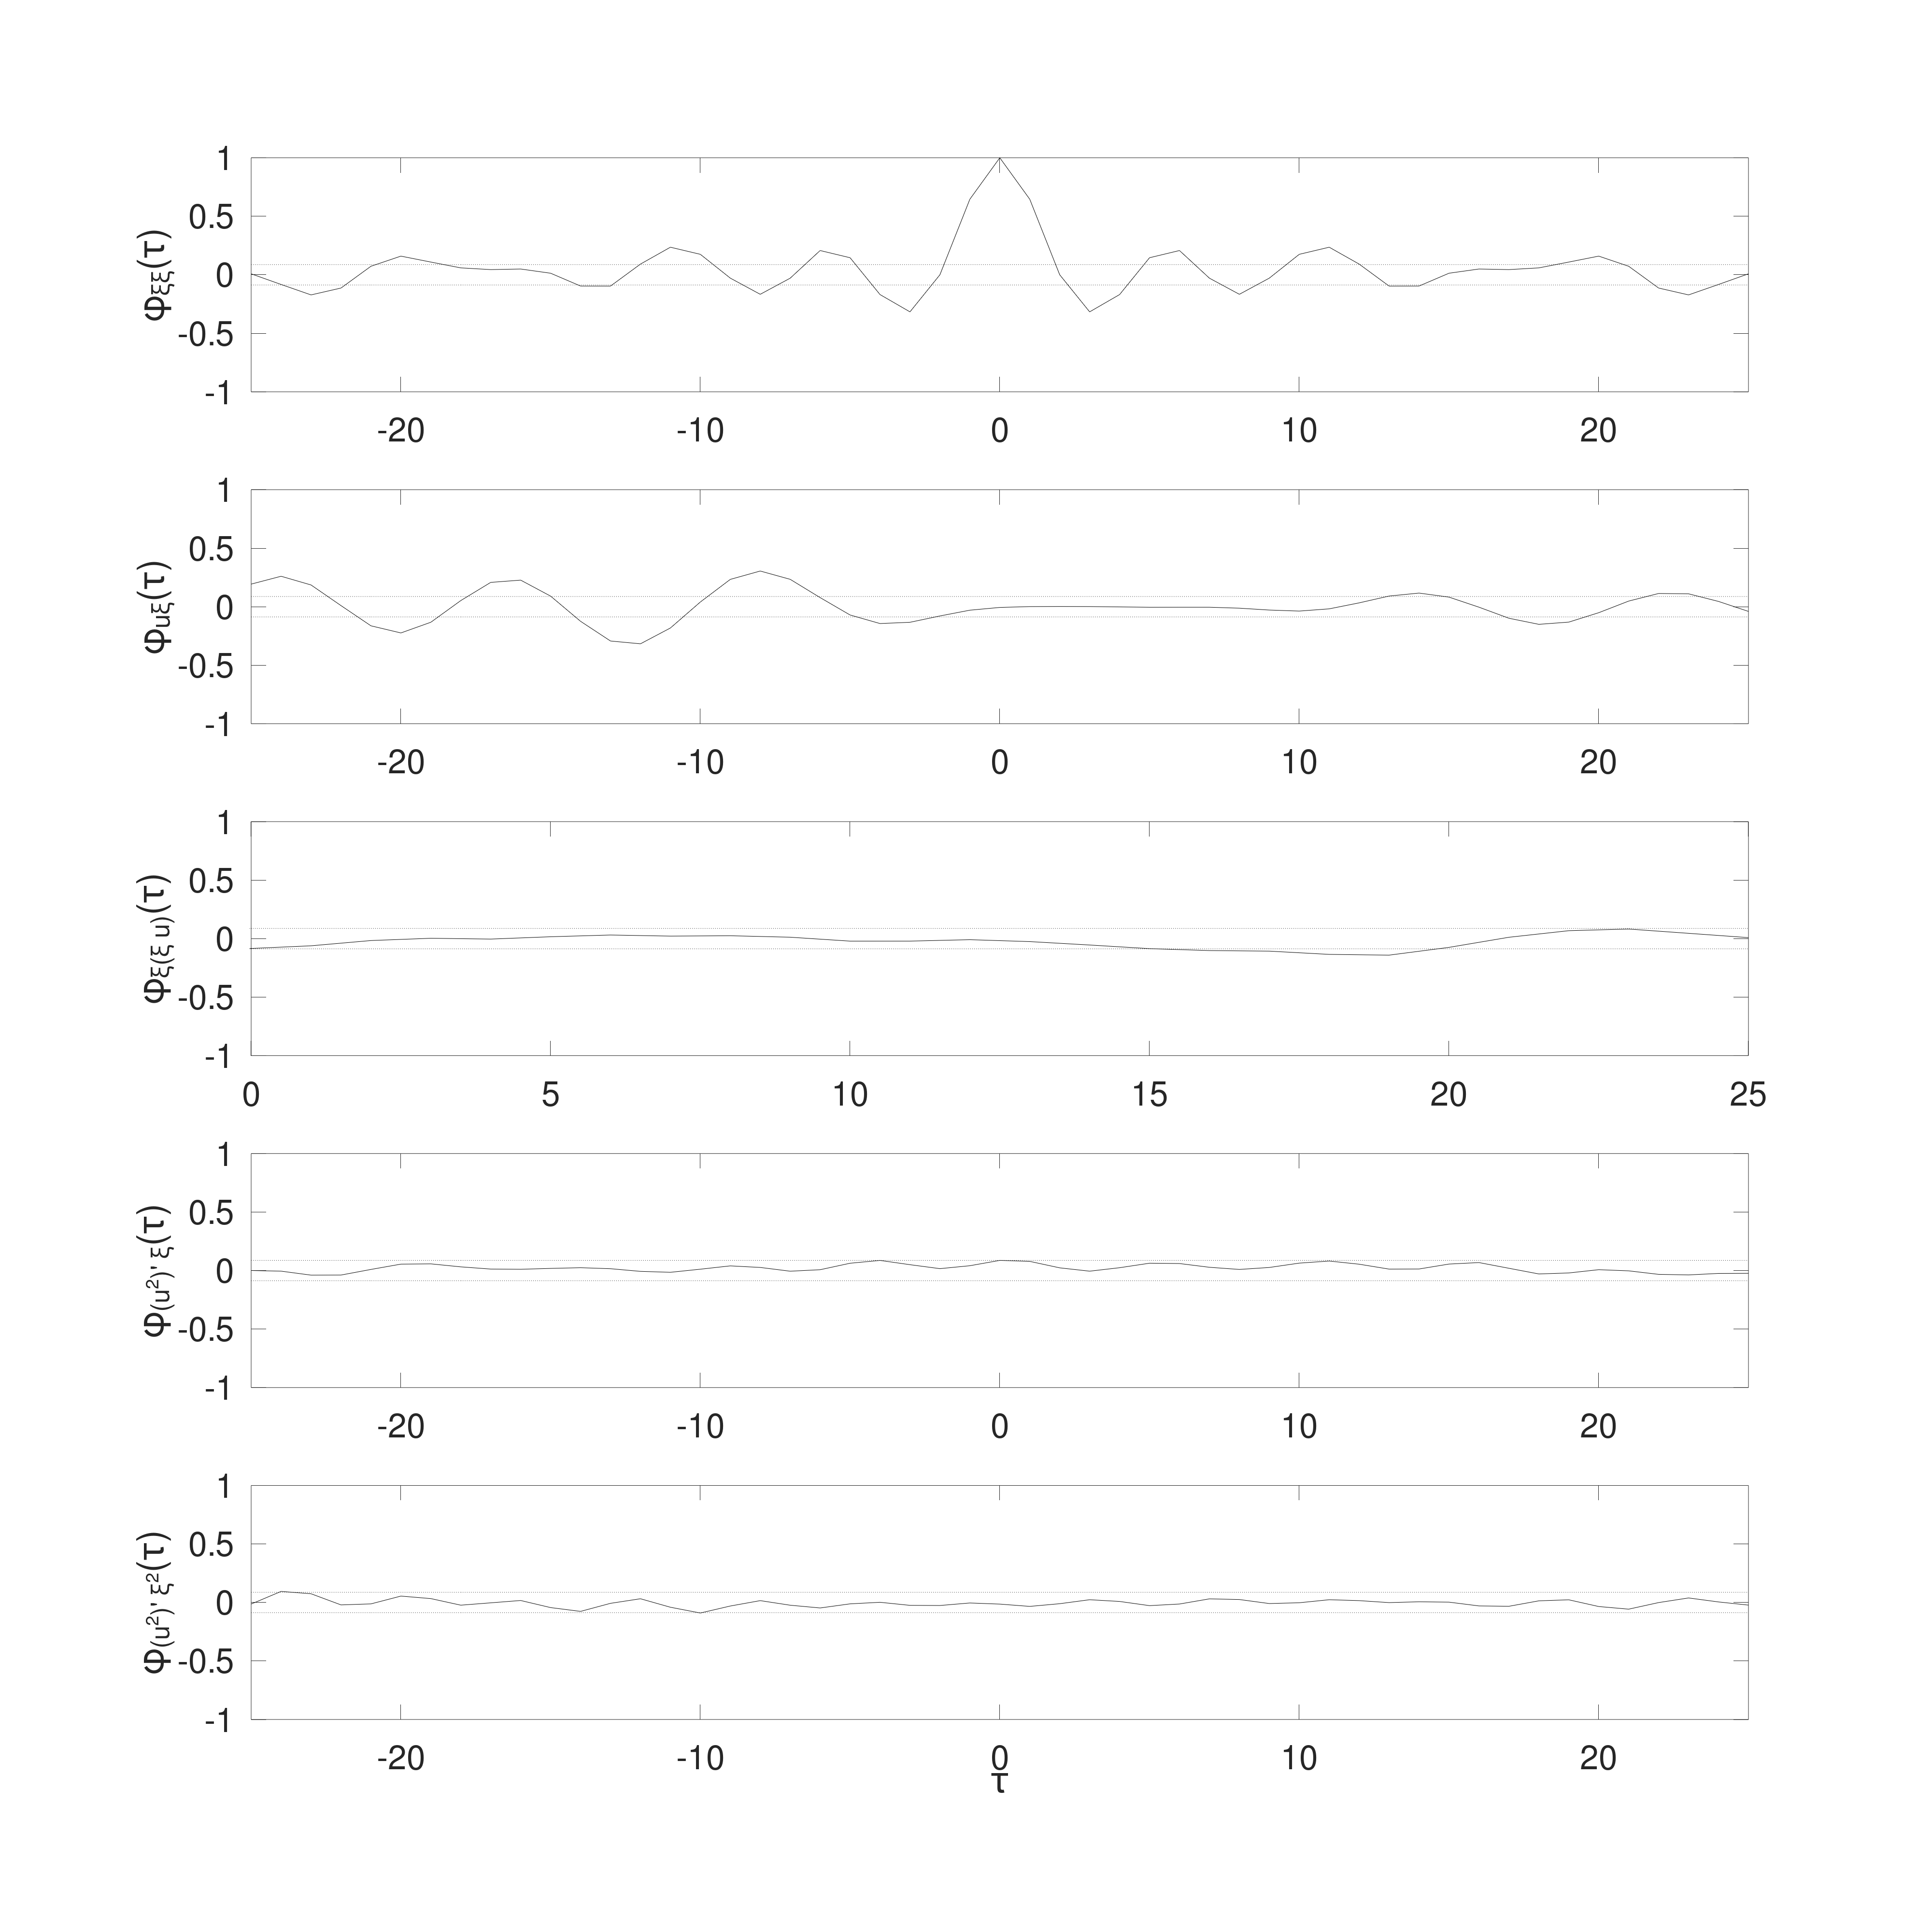

In [48]:
na = 4;
nb = 6;
p = max([na nb]);

%Step 1 - Gerando matriz
[Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
[PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

%Step 2 - Resolvendo sistema
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

%Step 3 - Simulando
yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);
plot_xcorrel(Y1-yhat_TRA_OSA,UTRA(p+1:end))

Nota-se, por esses resultados, que o modelo apresentou uma significativa melhora, porém ficou longe do ideal segundo as métricas de erro aplicadas.

### 4.4 - Comparando resultados de treino (nova validação)

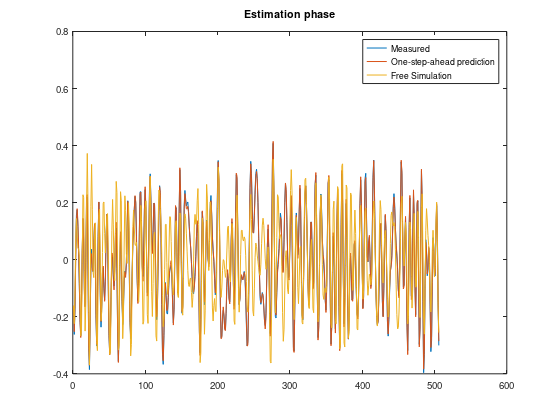

In [49]:
% plot predictions
figure
plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
title('Estimation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 4.5 - Comparando os resultados de validação (novo treino)

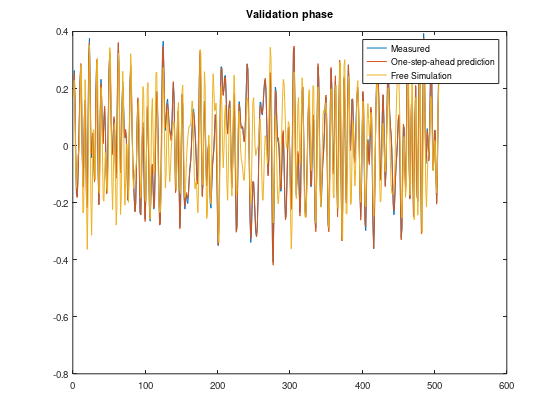

In [50]:
figure
plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
title('Validation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

# Parte 5 - Conclusões

* O modelo encontrado é bom, porém cabe melhorias
* Valores altos de `na` temdem a causar instabilidade, porém um valor de `na = 4` mostrou-se bom em par com `nb = 6`
* valores altos de `nb`, se não associados a valores altos de `na`, tendem a melhorar o resultado
* Apesar das melhorias desempenhadas, o $R^2$ da FS do modelo não ultrapassou 0.5 no range analisado
* O resultado dos testes estatístios de autocorrelação indicam que o modelo ainda pode melhorar
* O modelo não deve poder ser melhorado com este dataset e com este método de ajuste